## K-Means Clustering on User's Purchase Patterns

### Importing Libraries

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_columns', 150)
import gc
import os
import matplotlib
matplotlib.rcParams['figure.dpi'] = 120 
matplotlib.rcParams['figure.figsize'] = (8,6) 
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')
color = sns.color_palette()
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering


import matplotlib.pyplot as plt
%matplotlib inline
import scipy.cluster.hierarchy as shc
from scipy.spatial.distance import squareform, pdist
from scipy.spatial import distance_matrix

from kneed import KneeLocator
root = '/instacart-market-basket-analysis/'

### Importing Dataset

In [2]:
aisles = pd.read_csv(os.getcwd() + root + 'aisles.csv')
departments = pd.read_csv(os.getcwd() + root + 'departments.csv')
orders = pd.read_csv(os.getcwd() + root + 'orders.csv')
order_products_prior = pd.read_csv(os.getcwd() + root + 'order_products__prior.csv')
products = pd.read_csv(os.getcwd() + root + 'products.csv')

In [3]:
order_products = order_products_prior.merge(products, on ='product_id', how='left')
order_products = order_products.merge(aisles, on ='aisle_id', how='left')
order_products = order_products.merge(departments, on ='department_id', how='left')
order_products = order_products.merge(orders, on='order_id', how='left')

In [4]:
order_products.shape

(32434489, 15)

In [5]:
order_products.head()

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,aisle,department,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,eggs,dairy eggs,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,fresh vegetables,produce,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,spices seasonings,pantry,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,oils vinegars,pantry,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,baking ingredients,pantry,202279,prior,3,5,9,8.0


### Question: Pattern of No. of products VS Reorder count

In [15]:
filtered_orders = order_products.groupby('order_id').agg(no_of_products=('add_to_cart_order', 'max'), 
                                                         reordered_count=('reordered', 'sum'),).copy()

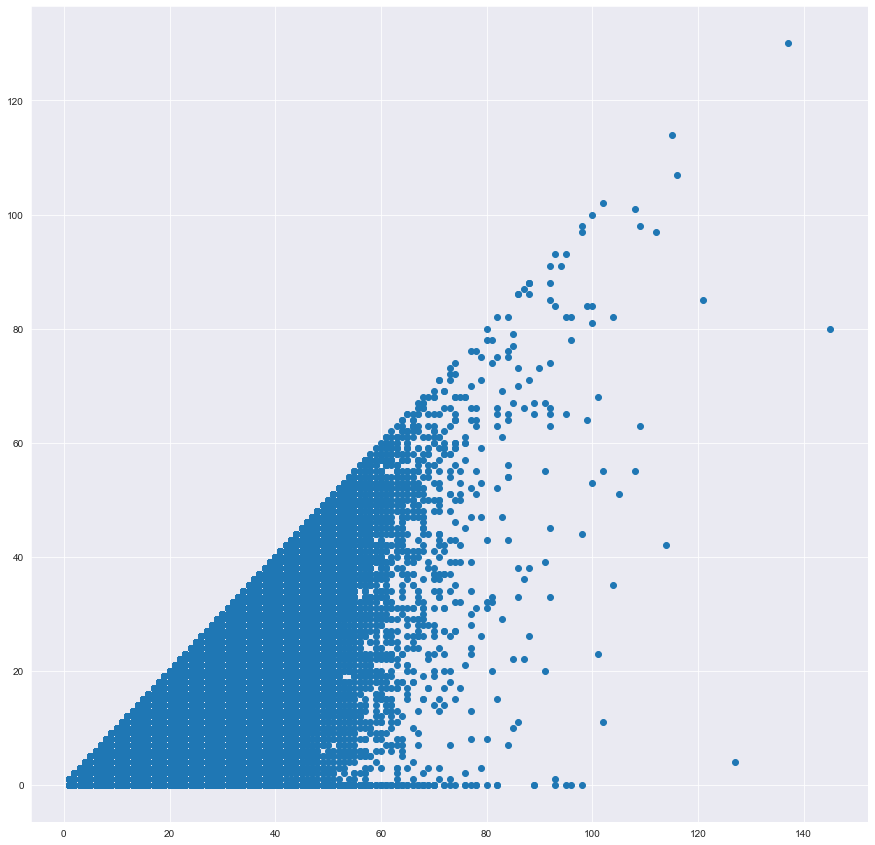

In [16]:
plt.figure(figsize= (15,15))

plt.scatter(filtered_orders["no_of_products"], filtered_orders["reordered_count"])

plt.show()

### FIltering Data based on certain conditions

#### Orders made only on Weekends (Saturday and Sunday)

In [35]:
order_products_weekend = order_products[(order_products["order_dow"] == 0) | (order_products["order_dow"] == 1)].copy()

In [36]:
order_products_weekend.shape

(11875522, 15)

In [40]:
cross_wkend_df = pd.crosstab(order_products_weekend.user_id, order_products_weekend.aisle)
cross_wkend_df.head()

(186882, 134)

In [38]:
df = cross_wkend_df.div(cross_wkend_df.sum(axis=1), axis=0)
df.shape

(186882, 134)

#### Orders made only on Weekends (Saturday and Sunday) which are reordered

In [42]:
order_products_weekend_reordered = order_products_weekend[order_products_weekend["reordered"] == 1].copy()

In [43]:
order_products_weekend_reordered.shape

(7055651, 15)

In [44]:
cross_wkend_reordrd_df = pd.crosstab(order_products_weekend_reordered.user_id, order_products_weekend_reordered.aisle)
cross_wkend_reordrd_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,7,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,2,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,8,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,2,0,0,0,0,0,0,1,0,0
5,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2
7,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,11,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,5,0,0,0,0,0,1,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,3,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,6,0,0,0,0,1,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,7,0,0,1,0,0,0,0,0,0,0,0,0,0,3


In [45]:
cross_wkend_reordrd_df.shape

(171774, 134)

#### Orders made only on Wednesday

In [46]:
order_products_wed = order_products[(order_products["order_dow"] == 4)].copy()

In [47]:
cross_wed_df = pd.crosstab(order_products_wed.user_id, order_products_wed.aisle)
cross_wed_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,3,0,0,0,0,0,1,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
2,0,0,0,0,0,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
14,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,2,0,1,0,0,0,0,0,0,0,0,0,1,0,4,2,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,0,0


In [48]:
df = cross_wed_df.div(cross_wed_df.sum(axis=1), axis=0)
df.shape

(132186, 134)

#### Orders made only on Sunday Morning (7AM to 12PM)

In [74]:
order_products_sun_mor = order_products[(order_products["order_dow"] == 1) &
                                        ((order_products["order_hour_of_day"] >=7) & 
                                         (order_products["order_hour_of_day"] <=12))].copy()

In [75]:
cross_sun_mor_df = pd.crosstab(order_products_sun_mor.user_id, order_products_sun_mor.aisle)
cross_sun_mor_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,6,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,1,1,0,0,0,0,1,0,15
8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
12,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,2,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,2,0,0,0,1,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [76]:
cross_sun_mor_df.shape

(92486, 134)

#### All orders made

In [6]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [7]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.shape

(206209, 134)

In [8]:
df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.016949,0.0,0.000000,0.0,0.000000,0.0,0.050847,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.033898,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.084746,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.152542,0.000000,0.000000,0.0,0.000000,0.135593,0.0,0.000000,0.0,0.0,0.000000,0.033898,0.0,0.000000,0.000000,0.203390,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.220339,0.000000,0.033898,0.0,0.000000,0.0,0.0,0.016949,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.016949
2,0.0,0.015385,0.0,0.0,0.0,0.0,0.010256,0.0,0.0,0.0,0.0,0.005128,0.005128,0.010256,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.005128,0.0,0.000000,0.061538,0.0,0.0,0.0,0.0,0.025641,0.0,0.056410,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.030769,0.0,0.0,0.0,0.0,0.0,0.0,0.046154,0.169231,0.000000,0.000000,0.000000,0.0,0.005128,0.000000,0.0,0.0,0.061538,0.0,0.0,0.0,0.020513,0.0,0.0,0.005128,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.005128,0.0,0.0,0.0,0.0,0.051282,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.015385,0.000000,0.005128,0.0,0.000000,0.025641,0.0,0.005128,0.0,0.0,0.015385,0.000000,0.0,0.005128,0.000000,0.051282,0.0,0.000000,0.005128,0.0,0.0,0.000000,0.025641,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.005128,0.0,0.000000,0.0,0.0,0.015385,0.005128,0.005128,0.000000,0.0,0.0,0.0,0.010256,0.0,0.215385
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.

## Which group of people buy the most product (by Aisle)?

### Performing PCA Transformation

Text(0, 0.5, 'Cumulative Explained Variance')

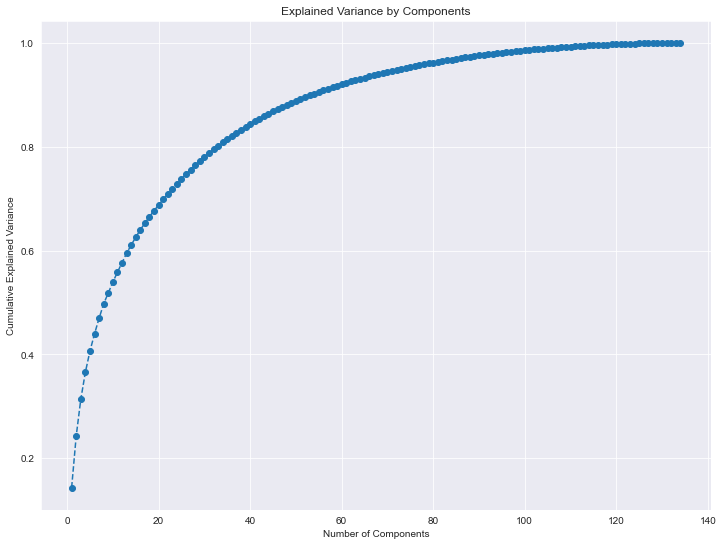

In [85]:
pca = PCA()
df_pca = pca.fit_transform(df)
pca.explained_variance_ratio_
plt.figure(figsize = (12,9))
plt.plot(range(1,135),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [86]:
pca = PCA(n_components=30)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.shape

(206209, 30)

In [87]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
0,-0.113443,0.039084,-0.042862,0.018864,-0.088355,-0.104502,-0.116428,0.083680,-0.062756,-0.026741,-0.021004,-0.010379,-0.059380,0.051923,0.052821,0.001915,-0.028467,0.062243,0.011625,-0.053987,-0.029077,0.025419,-0.010217,-0.007220,0.074965,0.043803,0.103883,0.046576,-0.024428,-0.006496
1,-0.036988,0.108884,-0.066406,-0.123269,0.098847,-0.033948,-0.054729,-0.053366,-0.020430,-0.008158,0.018890,-0.034210,0.054372,0.014974,-0.003494,-0.002120,-0.002772,-0.005156,-0.000593,-0.008194,0.001253,0.015698,0.013116,0.039366,0.008168,-0.002937,-0.002045,0.001117,0.004313,0.000529
2,0.064282,0.103962,0.000710,-0.012221,-0.046982,0.112244,-0.029812,0.007853,0.012346,0.001803,-0.008519,0.086208,-0.039940,0.092554,0.014705,0.030072,-0.060887,0.007641,-0.000754,-0.038058,-0.002496,0.004922,0.021003,0.055915,-0.001612,0.001784,0.015134,-0.006157,-0.007549,0.000621
3,-0.093210,0.054093,0.001865,-0.003968,-0.071349,-0.019291,-0.025100,-0.038246,0.006592,-0.000465,-0.059233,-0.056036,0.128430,0.030161,-0.037137,0.008871,-0.002828,-0.020732,0.003431,0.039063,-0.005984,-0.005234,0.026432,0.002708,0.010328,0.006573,0.015337,-0.005792,0.033862,-0.012371
4,0.094629,-0.037051,-0.024951,-0.021575,0.055366,0.107661,-0.008029,0.103938,0.051640,-0.025833,0.036006,-0.011711,0.006601,-0.007641,-0.002469,-0.005212,-0.013429,-0.005200,-0.017767,-0.005802,-0.000343,-0.007068,0.003136,-0.002068,0.011325,0.001710,-0.009738,0.000786,-0.004046,0.000178


In [88]:
pca.explained_variance_ratio_

array([0.14354181, 0.09937617, 0.07049654, 0.05219392, 0.0407219 ,
       0.03321593, 0.03003237, 0.02783649, 0.0210368 , 0.02058231,
       0.01908578, 0.01840872, 0.01814939, 0.01572972, 0.0150777 ,
       0.01442255, 0.01272645, 0.01249289, 0.01153544, 0.01096755,
       0.01069324, 0.01015701, 0.01003549, 0.00976324, 0.00944403,
       0.00915774, 0.00885586, 0.00837709, 0.00789399, 0.00767009])

Text(0, 0.5, 'variance %')

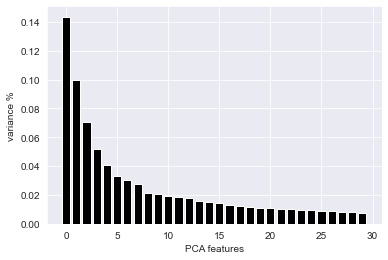

In [89]:
# Plot the explained variances to verify the variation.
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

### Running K-Means Algorithm

In [204]:
Sum_of_squared_distances = []
K_ss = range(2,20)
silhouettes = []
for k in K_ss:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)
    silhouettes.append(silhouette_score(df_pca, km.labels_))

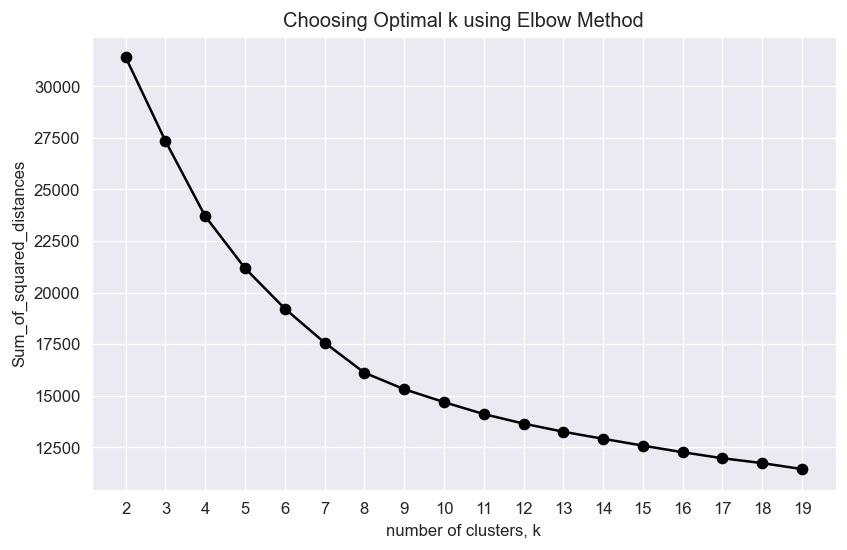

In [207]:
plt.subplots(figsize = (8, 5))
plt.plot(K_ss, Sum_of_squared_distances, '-o', color='black') 
plt.xlabel('number of clusters, k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Choosing Optimal k using Elbow Method')
plt.xticks(K_ss)
plt.show()

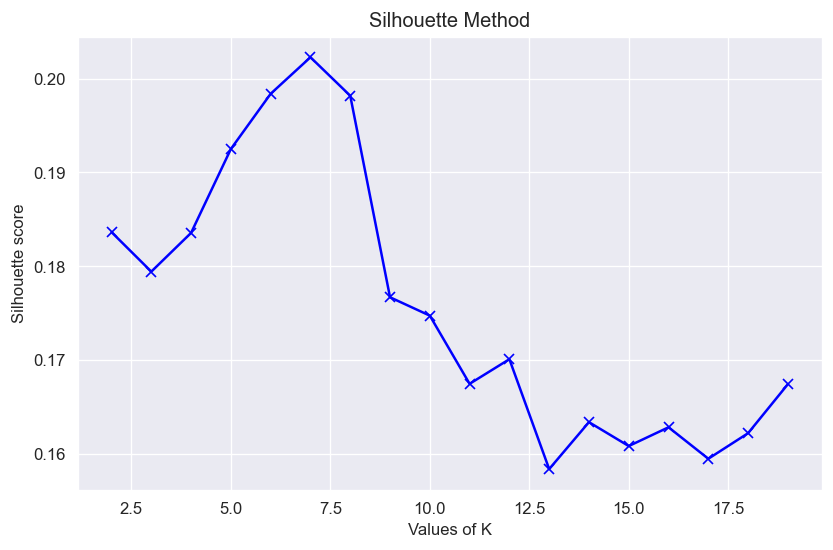

Suggested number of clusters:  3


In [206]:
fig = plt.figure(figsize= (8, 5))
plt.plot(K_ss, silhouettes, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Silhouette score')
plt.title('Silhouette Method')
plt.grid(True)
plt.show()

kl = KneeLocator(K_ss, silhouettes, curve="convex", direction="decreasing")
print('Suggested number of clusters: ', kl.elbow)

In [211]:
k_culster = 5

clusterer = KMeans(n_clusters=k_culster,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print("k-Means Clustering:", metrics.silhouette_score(df_pca, clusterer.labels_, metric='euclidean'))
print("\n\n")
print(centers)

k-Means Clustering: 0.19256350927301077



[[-0.17956108  0.23856191  0.15147737  0.03296304 -0.00678561  0.00365342]
 [ 0.31990649  0.13560241 -0.08445968  0.01705529  0.00078525  0.00061045]
 [ 0.14262799 -0.19266261  0.19792997 -0.08083291 -0.00634679  0.00388626]
 [-0.11883458 -0.02828068 -0.09833973 -0.07891951 -0.02425747  0.00913029]
 [-0.07880728 -0.16169732 -0.05228111  0.24369466  0.07872848 -0.03402375]]


### Clustering visualisation of 1st and 2nd principal components

In [90]:
df_cluster = df_pca.iloc[:,[0, 1]]
df_cluster.columns = ["PCA_1", "PCA_2"]
df_cluster['cluster'] = c_preds
df_cluster.head()

C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_14376/2216291402.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster'] = c_preds


,PCA_1,PCA_2,cluster
0,-0.113443,0.039084,0
1,-0.036988,0.108884,2
2,0.064282,0.103962,2
3,-0.093210,0.054093,0
4,0.094629,-0.037051,4


In [213]:
# Applying Kernel Transformation

df_cluster['Z'] = df_cluster.apply(lambda row: np.linalg.norm([0,0] - row[['PCA_1', 'PCA_2']]), axis=1)
df_cluster.head()

C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_14376/998902403.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['Z'] = df_cluster.apply(lambda row: np.linalg.norm([0,0] - row[['PCA_1', 'PCA_2']]), axis=1)


,PCA_1,PCA_2,cluster,Z
0,-0.281820,0.079009,0,0.292686
1,-0.303599,0.166751,3,0.346378
2,0.253238,0.254307,2,0.358890
3,-0.097172,-0.339082,0,0.352731
4,-0.044112,0.224329,3,0.228625


In [214]:
print("k-Means Clustering:", silhouette_score(df_cluster[['Z']], clusterer.labels_))

k-Means Clustering: -0.08955820309469453


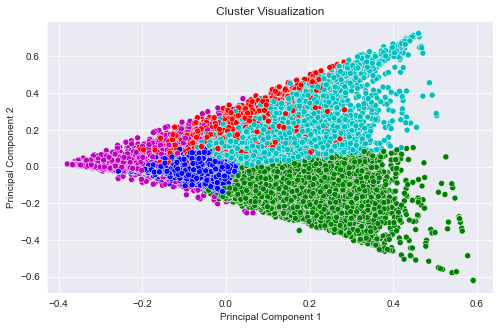

In [91]:
label_color_mapping = {0:'b', 1: 'm', 2: 'c',3:'r' , 4:'g'}
label_color = [label_color_mapping[l] for l in c_preds]

fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = df_cluster, x = "PCA_1", y = "PCA_2", c= label_color)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

### Top products per cluster

In [92]:
clust_prod = cross_df.copy()
clust_prod['cluster'] = c_preds
clust_prod.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0,2
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,4


In [99]:
c0 = clust_prod[clust_prod['cluster']==0]
c1 = clust_prod[clust_prod['cluster']==1]
c2 = clust_prod[clust_prod['cluster']==2]
c3 = clust_prod[clust_prod['cluster']==3]
c4 = clust_prod[clust_prod['cluster']==4]

In [100]:
c0.shape

(98987, 135)

In [101]:
c0.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     9.729389
fresh vegetables                 7.557780
yogurt                           7.199370
packaged vegetables fruits       5.982816
packaged cheese                  4.920131
chips pretzels                   4.479982
milk                             4.246709
water seltzer sparkling water    4.096871
refrigerated                     3.255236
ice cream ice                    3.096962
dtype: float64

In [102]:
c1.shape

(5374, 135)

In [103]:
c1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
water seltzer sparkling water    20.932825
fresh fruits                      3.294939
soft drinks                       2.802196
yogurt                            2.234090
energy granola bars               1.531448
chips pretzels                    1.323037
tea                               1.320804
milk                              1.320246
packaged vegetables fruits        1.238742
soy lactosefree                   1.079643
dtype: float64

In [104]:
c2.shape

(38281, 135)

In [105]:
c2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh fruits                     35.716805
fresh vegetables                 15.104151
packaged vegetables fruits       12.134427
yogurt                            9.932839
milk                              5.974191
packaged cheese                   5.155665
soy lactosefree                   3.789034
water seltzer sparkling water     3.623181
bread                             3.217732
chips pretzels                    3.134505
dtype: float64

In [106]:
c3.shape

(7933, 135)

In [107]:
c3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
packaged produce                 18.376276
fresh fruits                     10.881003
packaged vegetables fruits        4.230052
fresh vegetables                  3.108030
water seltzer sparkling water     1.718392
milk                              1.619438
packaged cheese                   1.558931
chips pretzels                    1.144964
frozen produce                    1.140048
nuts seeds dried fruit            1.031640
dtype: float64

In [108]:
c4.shape

(55634, 135)

In [109]:
c4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

aisle
fresh vegetables                 37.063379
fresh fruits                     21.709818
packaged vegetables fruits       12.013517
yogurt                            6.142754
packaged cheese                   5.004566
fresh herbs                       4.154060
milk                              3.990473
soy lactosefree                   3.709368
frozen produce                    3.297444
water seltzer sparkling water     3.076752
dtype: float64

**Customer Segmentation Results:**

**Cluster 0** results into 98987 consumers who mostly order fresh fruits with mean of 9.73. They purchase products from many aisles. Their mean orders are low compared to other clusters which tells us that either they are not frequent users of Instacart or they are new users and do not have many orders yet.

**Cluster 1** results into 5374 consumers having a very strong preference for water seltzer sparkling water with mean of 20.93.

**Cluster 2** results into 38281 consumers who have a very strong preference for fresh fruits with mean of 35.72.

**Cluster 3** results into 7933 consumers who prefer buying packaged produce with mean of 18.38 followed by fresh fruits.

**Cluster 4** results into 55643 consumers who orders products from fresh vegetables with mean of 37.063379.

## Which group of people buy the most product (by Departments)?

### Filtering data based on Department

In [110]:
order_products['department'].value_counts()[0:10]

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
Name: department, dtype: int64

In [111]:
cross_df = pd.crosstab(order_products.user_id, order_products.department)
cross_df.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,13,3,0,0,13,0,0,0,2,0,0,0,0,1,0,0,5,22
2,0,0,2,9,3,0,1,48,21,0,17,0,3,1,0,0,11,1,0,36,42
3,0,0,0,3,0,0,0,21,2,4,6,1,0,0,0,0,4,0,0,38,9
4,2,0,2,3,0,0,1,0,2,0,3,2,0,0,0,0,0,0,0,2,1
5,0,0,0,0,0,0,1,8,1,1,2,0,2,0,0,0,2,0,0,19,1


In [112]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.shape

(206209, 21)

In [113]:
df.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks
user_id,,,,,,,,,,,,,,,,,,,,,
1,0.000000,0.0,0.000000,0.220339,0.050847,0.0,0.000000,0.220339,0.000000,0.000000,0.000000,0.033898,0.000000,0.000000,0.0,0.0,0.016949,0.000000,0.0,0.084746,0.372881
2,0.000000,0.0,0.010256,0.046154,0.015385,0.0,0.005128,0.246154,0.107692,0.000000,0.087179,0.000000,0.015385,0.005128,0.0,0.0,0.056410,0.005128,0.0,0.184615,0.215385
3,0.000000,0.0,0.000000,0.034091,0.000000,0.0,0.000000,0.238636,0.022727,0.045455,0.068182,0.011364,0.000000,0.000000,0.0,0.0,0.045455,0.000000,0.0,0.431818,0.102273
4,0.111111,0.0,0.111111,0.166667,0.000000,0.0,0.055556,0.000000,0.111111,0.000000,0.166667,0.111111,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.111111,0.055556
5,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.027027,0.216216,0.027027,0.027027,0.054054,0.000000,0.054054,0.000000,0.0,0.0,0.054054,0.000000,0.0,0.513514,0.027027


### Performing PCA Transformation

Text(0, 0.5, 'Cumulative Explained Variance')

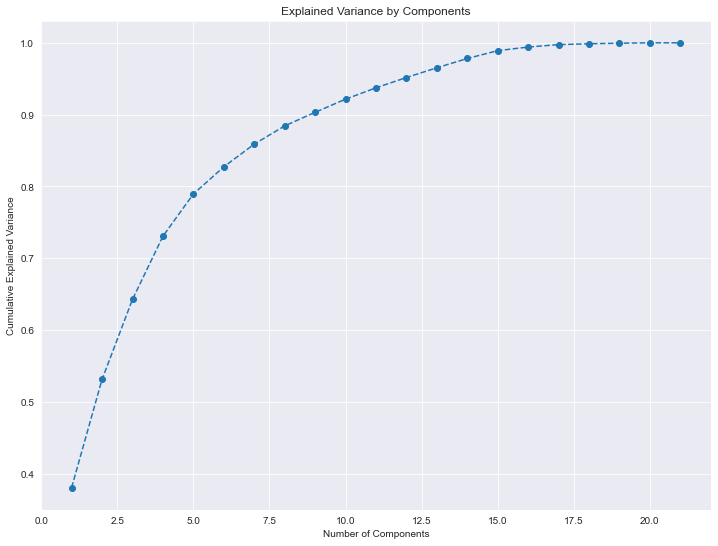

In [114]:
pca = PCA()
df_pca = pca.fit_transform(df)
pca.explained_variance_ratio_
plt.figure(figsize = (12,9))
plt.plot(range(1,22),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [115]:
pca = PCA(n_components=9)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.shape

(206209, 9)

In [116]:
df_pca.head()

,0,1,2,3,4,5,6,7,8
0,-0.266583,-0.047786,0.080290,-0.257217,0.030891,-0.029287,-0.019689,-0.036053,0.015083
1,-0.096643,0.102128,0.071972,-0.100870,0.050269,0.005953,-0.002581,-0.003230,-0.035350
2,0.157813,0.059159,-0.010402,-0.066775,0.040580,-0.023734,-0.015206,-0.041654,-0.006096
3,-0.180554,-0.104256,0.047553,0.162761,0.000880,-0.062219,0.113250,0.046428,-0.057027
4,0.261321,0.058563,-0.035833,-0.020320,0.016724,-0.006359,-0.006824,-0.028631,0.006379


In [117]:
pca.explained_variance_ratio_

array([0.38075333, 0.15065941, 0.1113776 , 0.08796864, 0.05871247,
       0.0378538 , 0.03159376, 0.02538798, 0.01893009])

Text(0, 0.5, 'variance %')

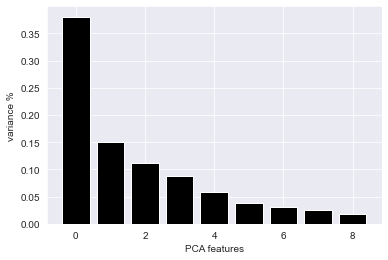

In [118]:
# Plot the explained variances to verify the variation.
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

### Running K-Means Algorithm

In [119]:
Sum_of_squared_distances = []
K_ss = range(1,20)
for k in K_ss:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

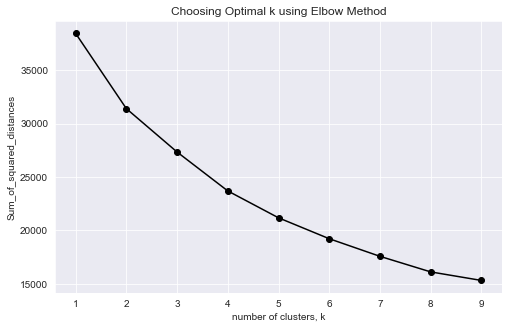

In [196]:
plt.subplots(figsize = (8, 5))
plt.plot(K_ss, Sum_of_squared_distances, '-o', color='black') 
plt.xlabel('number of clusters, k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Choosing Optimal k using Elbow Method')
plt.xticks(K_ss)
plt.show()

In [121]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-1.72008278e-01  4.09063918e-02  3.95014395e-02  1.63986567e-02
  -4.97183387e-03 -4.92569720e-03  1.50557393e-03 -1.81693497e-03
  -1.67899995e-03]
 [ 4.83331946e-02  3.41520773e-02 -1.23783282e-02 -3.79613160e-03
   5.71123841e-04  7.47936496e-03 -7.48121586e-05  5.27456545e-03
   1.95172793e-03]
 [-2.85938353e-01 -2.62017950e-01 -1.30147896e-01 -4.45345378e-02
   2.04033315e-02  8.07129639e-04 -4.12358540e-03 -6.16470609e-03
  -1.42111355e-04]
 [ 2.87861411e-01 -5.77890219e-02  2.77567197e-03 -5.01220885e-03
   4.70102253e-04 -8.23432449e-03 -1.05208471e-03 -6.40528476e-03
  -1.34777118e-03]]


C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_14376/736727946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster'] = c_preds


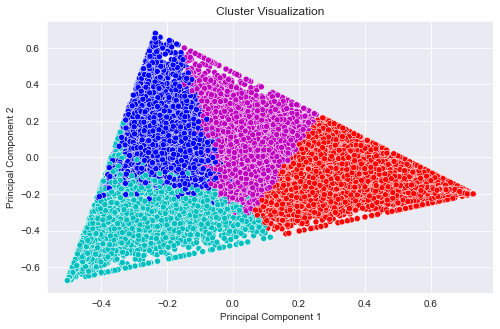

In [123]:
df_cluster = df_pca.iloc[:,[0, 1]]
df_cluster.columns = ["PCA_1", "PCA_2"]
df_cluster['cluster'] = c_preds
df_cluster.head()

label_color_mapping = {0:'b', 1: 'm', 2: 'c',3:'r' , 4:'g'}
label_color = [label_color_mapping[l] for l in c_preds]

fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = df_cluster, x = "PCA_1", y = "PCA_2", c= label_color)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [124]:
clust_prod = cross_df.copy()
clust_prod['cluster'] = c_preds
clust_prod.head()

department,alcohol,babies,bakery,beverages,breakfast,bulk,canned goods,dairy eggs,deli,dry goods pasta,frozen,household,international,meat seafood,missing,other,pantry,personal care,pets,produce,snacks,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,13,3,0,0,13,0,0,0,2,0,0,0,0,1,0,0,5,22,0
2,0,0,2,9,3,0,1,48,21,0,17,0,3,1,0,0,11,1,0,36,42,0
3,0,0,0,3,0,0,0,21,2,4,6,1,0,0,0,0,4,0,0,38,9,1
4,2,0,2,3,0,0,1,0,2,0,3,2,0,0,0,0,0,0,0,2,1,0
5,0,0,0,0,0,0,1,8,1,1,2,0,2,0,0,0,2,0,0,19,1,3


In [125]:
c0 = clust_prod[clust_prod['cluster']==0]
c1 = clust_prod[clust_prod['cluster']==1]
c2 = clust_prod[clust_prod['cluster']==2]
c3 = clust_prod[clust_prod['cluster']==3]

In [126]:
c0.shape

(67601, 22)

In [127]:
c0.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
dairy eggs      23.569799
snacks          18.201343
produce         17.163459
beverages       14.335927
frozen          13.514342
pantry           8.795728
bakery           6.152868
household        5.802873
deli             4.642328
canned goods     4.439683
dtype: float64

In [128]:
c1.shape

(86238, 22)

In [129]:
c1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
produce            60.812530
dairy eggs         35.126070
snacks             14.342123
frozen             12.276641
beverages          12.201048
pantry             11.212806
bakery              7.132714
canned goods        6.740312
deli                6.692653
dry goods pasta     5.535193
dtype: float64

In [130]:
c2.shape

(13162, 22)

In [131]:
c2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
beverages     32.525528
snacks        11.759915
dairy eggs     9.288254
produce        8.273743
household      3.090336
frozen         2.976827
pantry         2.911867
breakfast      1.805045
bakery         1.721623
deli           1.650737
dtype: float64

In [132]:
c3.shape

(39208, 22)

In [133]:
c3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

department
produce         75.642063
dairy eggs      17.068455
pantry           7.031244
snacks           6.771603
beverages        6.139334
frozen           5.737477
canned goods     4.473934
deli             3.533335
bakery           3.139053
meat seafood     3.068277
dtype: float64

**Customer Segmentation Results:**

**Cluster 0** results into 67601 consumers who mostly order from dairy with mean of 23.57.

**Cluster 1** results into 86238 consumers having a very strong preference for produce with mean of 60.81 followed by dairy.

**Cluster 2** results into 13162 consumers who have a very strong preference for bevarages with mean of 32.52.

**Cluster 3** results into 39208 consumers who again prefer buying from produce with mean of 75.64 followed by dairy.

## Which group of people buy the most product (by Hour of the Day)?

### Filtering data based on Hour of Day

In [135]:
order_products['order_hour_of_day'].value_counts()[0:10]

10    2764426
11    2738582
14    2691548
15    2664533
13    2663292
12    2620847
16    2537458
9     2456713
17    2089465
8     1719973
Name: order_hour_of_day, dtype: int64

In [136]:
cross_df = pd.crosstab(order_products.user_id, order_products.order_hour_of_day)
cross_df.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,15,14,5,0,0,5,0,6,8,6,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,66,55,44,14,0,0,16,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,15,25,19,10,9,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,6,0,5,0,7,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,9,0,17,0,0,0,0,0


In [137]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.shape

(206209, 24)

In [138]:
df.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23
user_id,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.254237,0.237288,0.084746,0.000000,0.000000,0.084746,0.000000,0.101695,0.135593,0.101695,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.338462,0.282051,0.225641,0.071795,0.000000,0.000000,0.082051,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.113636,0.170455,0.284091,0.215909,0.113636,0.102273,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.333333,0.000000,0.277778,0.000000,0.388889,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.297297,0.000000,0.000000,0.000000,0.243243,0.000000,0.459459,0.000000,0.0,0.0,0.0,0.0


### Performing PCA Transformation

Text(0, 0.5, 'Cumulative Explained Variance')

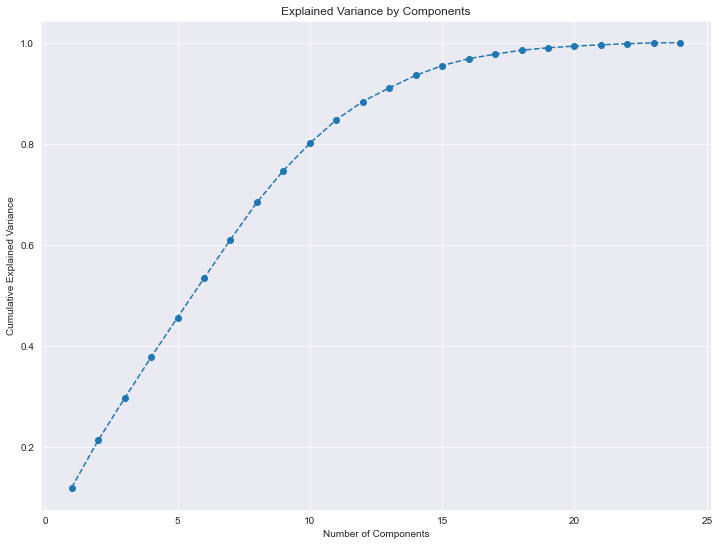

In [139]:
pca = PCA()
df_pca = pca.fit_transform(df)
pca.explained_variance_ratio_
plt.figure(figsize = (12,9))
plt.plot(range(1,25),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [140]:
pca = PCA(n_components=12)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.shape

(206209, 12)

In [141]:
df_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.006520,-0.022011,-0.099555,-0.014014,-0.065703,-0.061147,-0.038693,-0.146159,-0.036757,0.194250,-0.088964,-0.011708
1,0.324750,-0.116606,-0.063511,0.110886,-0.041985,-0.000020,-0.009665,-0.030354,0.068671,-0.149945,0.029520,-0.012147
2,-0.296820,-0.089106,-0.023290,0.071402,0.015163,-0.058835,0.053162,-0.001362,0.051380,-0.023933,0.000833,-0.061781
3,0.003035,0.231093,-0.022088,0.285099,-0.053883,0.310218,-0.069187,-0.002668,-0.002488,-0.013527,-0.005514,-0.012818
4,-0.166612,-0.057182,0.231719,-0.091859,-0.118322,-0.153056,0.066937,-0.030309,-0.237181,-0.202187,-0.231214,-0.012697


In [142]:
pca.explained_variance_ratio_

array([0.11929573, 0.09323083, 0.08358426, 0.08123477, 0.07857688,
       0.07779809, 0.07643305, 0.07386193, 0.06302608, 0.0537576 ,
       0.04687815, 0.03607845])

Text(0, 0.5, 'variance %')

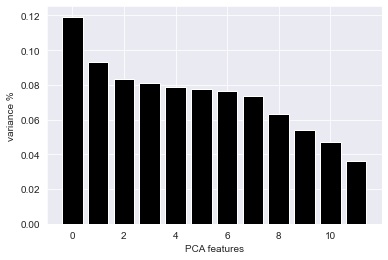

In [143]:
# Plot the explained variances to verify the variation.
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

### Running K-Means Algorithm

In [154]:
Sum_of_squared_distances = []
K_ss = range(1,10)
for k in K_ss:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

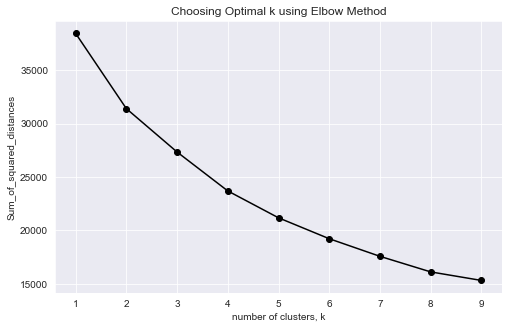

In [197]:
plt.subplots(figsize = (8, 5))
plt.plot(K_ss, Sum_of_squared_distances, '-o', color='black') 
plt.xlabel('number of clusters, k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Choosing Optimal k using Elbow Method')
plt.xticks(K_ss)
plt.show()

In [159]:
clusterer = KMeans(n_clusters=5,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[ 0.1220942   0.0450927   0.12792632  0.15688835  0.08783128  0.02933227
  -0.02567459 -0.01718047  0.00017072 -0.00523667 -0.00017146 -0.00298681]
 [-0.11795574 -0.08323991  0.04842837 -0.02491699  0.02009496 -0.00592289
   0.00350458  0.01318663 -0.01202012 -0.00497977  0.0113382   0.00557344]
 [ 0.14089324 -0.08138083 -0.06416044 -0.03016462 -0.02159686 -0.00949068
   0.01346295 -0.01225505  0.00898651  0.01057421 -0.01130809 -0.00427357]
 [-0.11897961  0.06136146 -0.11934234  0.12599631 -0.1266216   0.03268442
  -0.05228981  0.0066689   0.00180158 -0.00201998 -0.00150854 -0.00287885]
 [-0.00204306  0.13909335  0.00111727 -0.08135878  0.01640908 -0.01412716
   0.021084    0.00170224  0.00479176 -0.00118119 -0.00158355  0.00044142]]


C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_14376/736727946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster'] = c_preds


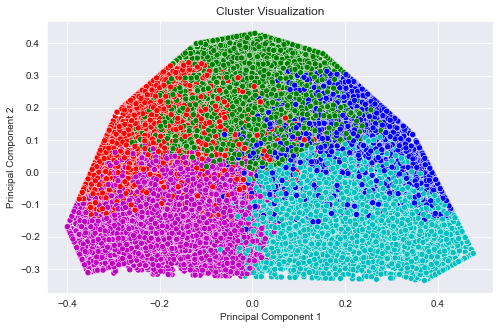

In [160]:
df_cluster = df_pca.iloc[:,[0, 1]]
df_cluster.columns = ["PCA_1", "PCA_2"]
df_cluster['cluster'] = c_preds
df_cluster.head()

label_color_mapping = {0:'b', 1: 'm', 2: 'c',3:'r' , 4:'g'}
label_color = [label_color_mapping[l] for l in c_preds]

fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = df_cluster, x = "PCA_1", y = "PCA_2", c= label_color)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [161]:
clust_prod = cross_df.copy()
clust_prod['cluster'] = c_preds
clust_prod.head()

order_hour_of_day,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,cluster
user_id,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,15,14,5,0,0,5,0,6,8,6,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,66,55,44,14,0,0,16,0,0,0,0,0,0,0,0,2
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,10,15,25,19,10,9,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,0,6,0,5,0,7,0,0,0,0,0,0,0,0,3
5,0,0,0,0,0,0,0,0,0,0,0,0,11,0,0,0,9,0,17,0,0,0,0,0,1


In [162]:
c0 = clust_prod[clust_prod['cluster']==0]
c1 = clust_prod[clust_prod['cluster']==1]
c2 = clust_prod[clust_prod['cluster']==2]
c3 = clust_prod[clust_prod['cluster']==3]
c4 = clust_prod[clust_prod['cluster']==4]

In [163]:
c0.shape

(24374, 25)

In [164]:
c0.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_hour_of_day
11    31.602281
12    10.994338
10    10.942028
13     8.253467
14     7.234881
9      6.677936
15     6.396693
16     6.009806
17     4.502544
8      3.748749
dtype: float64

In [165]:
c1.shape

(60343, 25)

In [166]:
c1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_hour_of_day
17    19.090151
16    18.731004
18    16.095670
19    12.078617
15    10.984886
14    10.151683
13     8.891852
12     8.429296
20     8.287341
11     7.966160
dtype: float64

In [167]:
c2.shape

(50348, 25)

In [168]:
c2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_hour_of_day
9     29.277906
10    28.631068
8     19.376023
11    15.324005
12    13.077024
13    11.475352
14    10.841543
15    10.076647
7      8.871574
16     8.756316
dtype: float64

In [169]:
c3.shape

(24032, 25)

In [170]:
c3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_hour_of_day
15    30.963715
16    11.739264
14    10.462508
13     8.047686
17     7.032498
12     6.940954
11     6.157082
10     5.505992
18     4.479444
9      4.144349
dtype: float64

In [171]:
c4.shape

(47112, 25)

In [172]:
c4.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_hour_of_day
13    24.503269
14    23.461899
12    21.629627
15    12.614620
11    12.058626
16    11.413419
10    10.533410
9      7.625382
17     7.238326
8      5.425284
dtype: float64

**Customer Segmentation Results:**

**Cluster 0** results into 24374 consumers who mostly shop at 11 AM.

**Cluster 1** results into 60343 consumers having a very strong preference for shopping between 4 PM and 6 PM.

**Cluster 2** results into 50348 consumers who have a very strong preference for shopping at 9 AM and 10 AM.

**Cluster 3** results into 24032 consumers who prefer shopping at 3 PM.

**Cluster 4** results into 47112 consumers who prefer shopping between 12 PM and 2 PM.

## Which group of people buy the most product (by Day of the Week)?

### Filtering data based on Day of the Week

In [173]:
order_products['order_dow'].value_counts()[0:10]

0    6209666
1    5665856
6    4500304
2    4217798
5    4209533
3    3844117
4    3787215
Name: order_dow, dtype: int64

In [174]:
cross_df = pd.crosstab(order_products.user_id, order_products.order_dow)
cross_df.head()

order_dow,0,1,2,3,4,5,6
user_id,,,,,,,
1,0,17,9,11,22,0,0
2,0,64,87,29,9,6,0
3,46,16,5,21,0,0,0
4,0,0,0,0,9,5,4
5,9,12,0,16,0,0,0


In [175]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.shape

(206209, 7)

In [176]:
df.head()

order_dow,0,1,2,3,4,5,6
user_id,,,,,,,
1,0.000000,0.288136,0.152542,0.186441,0.372881,0.000000,0.000000
2,0.000000,0.328205,0.446154,0.148718,0.046154,0.030769,0.000000
3,0.522727,0.181818,0.056818,0.238636,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.500000,0.277778,0.222222
5,0.243243,0.324324,0.000000,0.432432,0.000000,0.000000,0.000000


### Performing PCA Transformation

Text(0, 0.5, 'Cumulative Explained Variance')

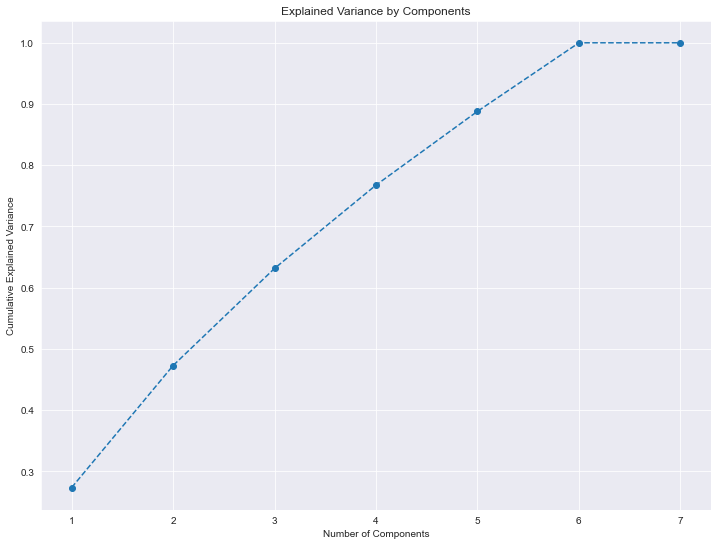

In [177]:
pca = PCA()
df_pca = pca.fit_transform(df)
pca.explained_variance_ratio_
plt.figure(figsize = (12,9))
plt.plot(range(1,8),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [178]:
pca = PCA(n_components=6)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.shape

(206209, 6)

In [179]:
df_pca.head()

,0,1,2,3,4,5
0,-0.281820,0.079009,-0.055528,-0.075392,-0.172538,0.172063
1,-0.303599,0.166751,-0.016726,-0.182949,0.192819,-0.033366
2,0.253238,0.254307,-0.145275,-0.019636,-0.096457,-0.146538
3,-0.097172,-0.339082,-0.029864,0.144002,-0.136057,0.329338
4,-0.044112,0.224329,-0.037825,-0.035712,-0.244598,-0.273577


In [180]:
pca.explained_variance_ratio_

array([0.27351962, 0.19928927, 0.15866823, 0.13607508, 0.12047742,
       0.11197038])

Text(0, 0.5, 'variance %')

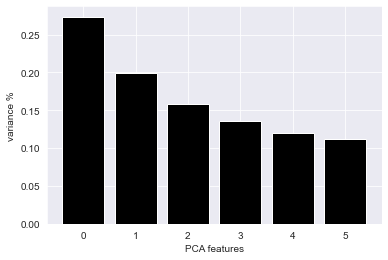

In [181]:
# Plot the explained variances to verify the variation.
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')

### Running K-Means Algorithm

In [182]:
Sum_of_squared_distances = []
K_ss = range(1,10)
for k in K_ss:
    km = KMeans(n_clusters=k)
    km = km.fit(df_pca)
    Sum_of_squared_distances.append(km.inertia_)

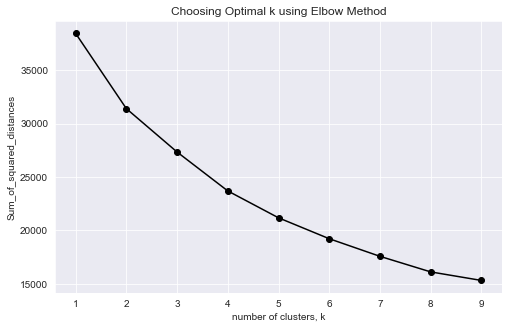

In [198]:
plt.subplots(figsize = (8, 5))
plt.plot(K_ss, Sum_of_squared_distances, '-o', color='black') 
plt.xlabel('number of clusters, k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Choosing Optimal k using Elbow Method')
plt.xticks(K_ss)
plt.show()

In [184]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(df_pca)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df_pca)
print(centers)

[[-1.15140813e-01 -6.95958041e-02 -9.89636530e-02  5.20529846e-03
  -1.89490431e-03  9.02685864e-04]
 [ 1.29086729e-01 -1.97929794e-01  1.86704226e-01 -5.90541092e-02
   2.38041357e-03 -1.23748000e-03]
 [ 3.10830819e-01  1.29421475e-01 -8.58328141e-02  1.98721318e-02
   3.29623117e-03 -1.15018518e-03]
 [-1.79492319e-01  2.20115359e-01  1.33456837e-01  2.51993206e-02
  -1.34019383e-03  3.09051168e-04]]


C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_14376/736727946.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster'] = c_preds


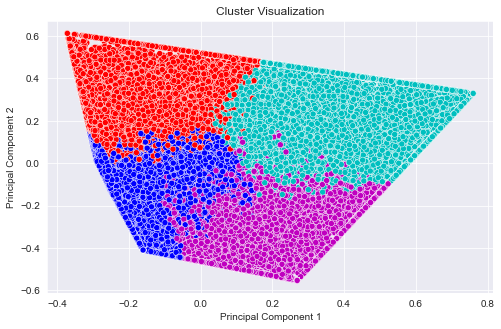

In [185]:
df_cluster = df_pca.iloc[:,[0, 1]]
df_cluster.columns = ["PCA_1", "PCA_2"]
df_cluster['cluster'] = c_preds
df_cluster.head()

label_color_mapping = {0:'b', 1: 'm', 2: 'c',3:'r' , 4:'g'}
label_color = [label_color_mapping[l] for l in c_preds]

fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = df_cluster, x = "PCA_1", y = "PCA_2", c= label_color)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Cluster Visualization")
plt.show();

In [186]:
clust_prod = cross_df.copy()
clust_prod['cluster'] = c_preds
clust_prod.head()

order_dow,0,1,2,3,4,5,6,cluster
user_id,,,,,,,,
1,0,17,9,11,22,0,0,0
2,0,64,87,29,9,6,0,3
3,46,16,5,21,0,0,0,2
4,0,0,0,0,9,5,4,0
5,9,12,0,16,0,0,0,3


In [187]:
c0 = clust_prod[clust_prod['cluster']==0]
c1 = clust_prod[clust_prod['cluster']==1]
c2 = clust_prod[clust_prod['cluster']==2]
c3 = clust_prod[clust_prod['cluster']==3]

In [188]:
c0.shape

(89461, 8)

In [189]:
c0.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_dow
5    30.088485
2    28.745900
4    28.727144
3    28.522965
1    24.516381
0    21.092823
6    16.287265
dtype: float64

In [190]:
c1.shape

(37796, 8)

In [191]:
c1.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_dow
6    53.049767
0    26.926236
5    18.302995
1    12.869695
4    10.705048
2     9.967801
3     9.808022
dtype: float64

In [192]:
c2.shape

(40013, 8)

In [193]:
c2.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_dow
0    68.109364
1    18.779422
6    18.669158
2    11.385250
5    10.049234
3     9.542174
4     8.805388
dtype: float64

In [194]:
c3.shape

(38939, 8)

In [195]:
c3.drop('cluster',axis=1).mean().sort_values(ascending=False)[0:10]

order_dow
1    57.391099
2    20.900896
0    14.887825
3    13.865508
4    11.821516
5    10.886438
6     7.477105
dtype: float64

**Customer Segmentation Results:**

**Cluster 0** results into 89461 consumers who mostly shop on Thursdays.

**Cluster 1** results into 37796 consumers having a very strong preference for shopping on Fridays.

**Cluster 2** results into 40013 consumers who have a very strong preference for shopping on Saturdays.

**Cluster 3** results into 38939 consumers who prefer shopping on Sundays.

### Trying Hierarchical Clustering

## Which group of people buy the most product (by Aisle)?

In [9]:
cross_df = pd.crosstab(order_products.user_id, order_products.aisle)
cross_df.head()

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,body lotions soap,bread,breakfast bakery,breakfast bars pastries,bulk dried fruits vegetables,bulk grains rice dried goods,buns rolls,butter,candy chocolate,canned fruit applesauce,canned jarred vegetables,canned meals beans,canned meat seafood,cat food care,cereal,chips pretzels,cleaning products,cocoa drink mixes,coffee,cold flu allergy,condiments,cookies cakes,crackers,cream,deodorants,diapers wipes,digestion,dish detergents,dog food care,doughs gelatins bake mixes,dry pasta,eggs,energy granola bars,energy sports drinks,eye ear care,facial care,feminine care,first aid,food storage,fresh dips tapenades,fresh fruits,fresh herbs,fresh pasta,fresh vegetables,frozen appetizers sides,frozen breads doughs,frozen breakfast,frozen dessert,frozen juice,frozen meals,frozen meat seafood,frozen pizza,frozen produce,frozen vegan vegetarian,fruit vegetable snacks,grains rice dried goods,granola,hair care,honeys syrups nectars,hot cereal pancake mixes,hot dogs bacon sausage,ice cream ice,ice cream toppings,indian foods,instant foods,juice nectars,kitchen supplies,kosher foods,latino foods,laundry,lunch meat,marinades meat preparation,meat counter,milk,mint gum,missing,more household,muscles joints pain relief,nuts seeds dried fruit,oils vinegars,oral hygiene,other,other creams cheeses,packaged cheese,packaged meat,packaged poultry,packaged produce,packaged seafood,packaged vegetables fruits,paper goods,pasta sauce,pickled goods olives,plates bowls cups flatware,popcorn jerky,poultry counter,prepared meals,prepared soups salads,preserved dips spreads,protein meal replacements,red wines,refrigerated,refrigerated pudding desserts,salad dressing toppings,seafood counter,shave needs,skin care,soap,soft drinks,soup broth bouillon,soy lactosefree,specialty cheeses,specialty wines champagnes,spices seasonings,spirits,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,3,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,0,0,0,0,8,0,0,0,0,0,2,0,0,0,12,0,0,0,0,0,0,0,0,0,0,0,0,0,13,0,2,0,0,0,0,1,0,0,0,0,0,0,0,0,1
2,0,3,0,0,0,0,2,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,1,0,0,12,0,0,0,0,5,0,11,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,9,33,0,0,0,0,1,0,0,0,12,0,0,0,4,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,10,0,0,0,0,0,0,0,3,0,1,0,0,5,0,1,0,0,3,0,0,1,0,10,0,0,1,0,0,0,5,0,0,0,0,0,0,0,0,1,0,0,0,0,3,1,1,0,0,0,0,2,0,42
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,19,0,0,5,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,1,5,0,0,0,0,14,1,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,15,0,0,0,0,4,1,0,0,0,0,0,2,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2,2,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0
5,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,1,1,6,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,2,0,0,0,0,0,0,0,0,1,0,0,3,0,0,0,0,0,1,0,0,0,1,0,0,0,0,8,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3


In [10]:
df = cross_df.div(cross_df.sum(axis=1), axis=0)
df.shape

(206209, 134)

(1000, 134)


Text(0, 0.5, 'Cumulative Explained Variance')

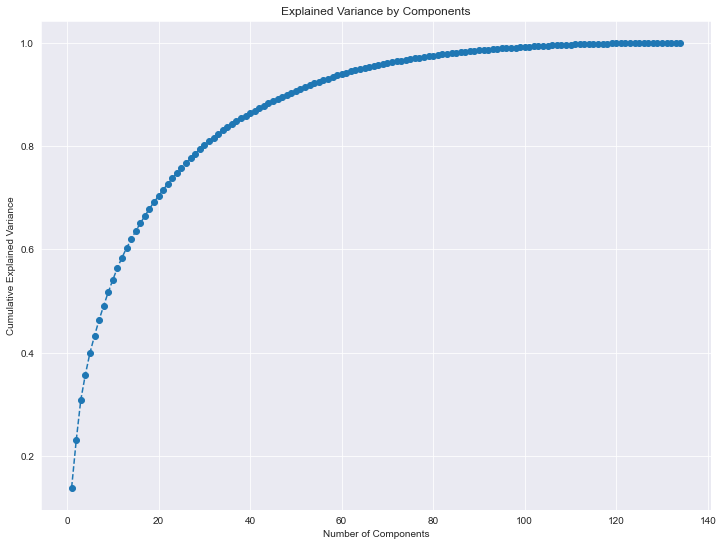

In [11]:
pca = PCA()
df_pca = pca.fit_transform(df.head(1000))

print(df_pca.shape)

pca.explained_variance_ratio_
plt.figure(figsize = (12,9))
plt.plot(range(1,135),pca.explained_variance_ratio_.cumsum(),marker = 'o',linestyle = '--')
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

In [12]:
pca = PCA(n_components=30)
df_pca = pca.fit_transform(df)
df_pca = pd.DataFrame(df_pca)
df_pca.shape

(206209, 30)

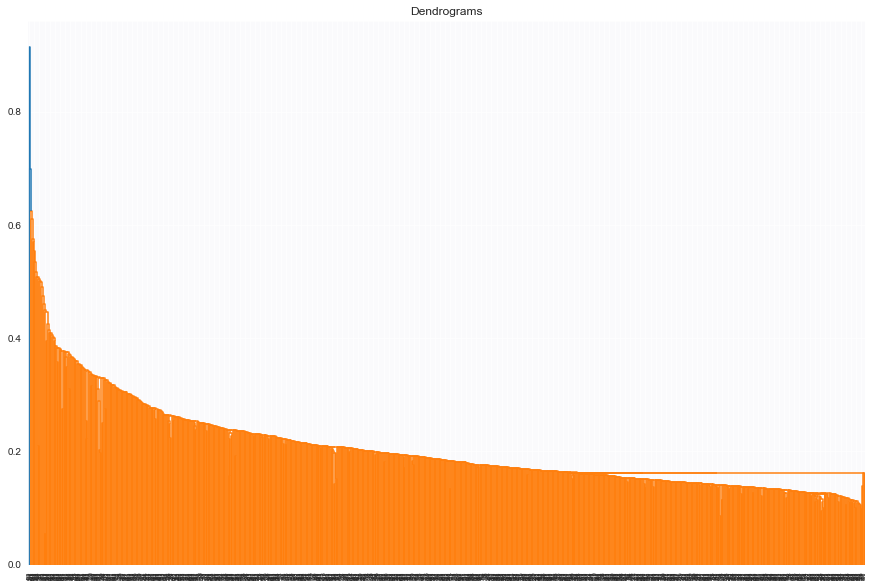

In [7]:
plt.figure(figsize=(15, 10))  
plt.title("Dendrograms")  
dend = shc.dendrogram(shc.linkage(df.head(1000), method='single'))

In [24]:
#Fit the model
clusters = 5
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='single')
labels = hc.fit_predict(df_pca)

In [34]:
df_cluster = df_pca.iloc[:,[0, 1]]
df_cluster.columns = ["PCA_1", "PCA_2"]
df_cluster['cluster'] = labels
df_cluster.groupby(['cluster']).size()

C:\Users\KATI-S~1\AppData\Local\Temp/ipykernel_25356/1527098693.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cluster['cluster'] = labels


cluster
0    206205
1         1
2         1
3         1
4         1
dtype: int64

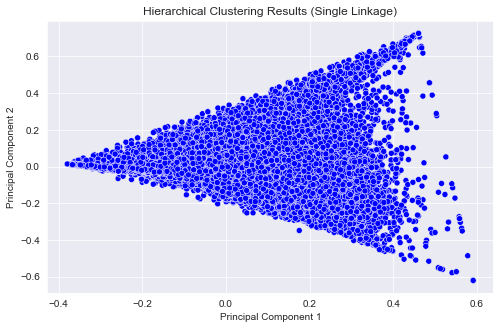

In [29]:
label_color_mapping = {0:'b', 1: 'm', 2: 'c',3:'r' , 4:'g'}
label_color = [label_color_mapping[l] for l in labels]

fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = df_cluster, x = "PCA_1", y = "PCA_2", c= label_color)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Hierarchical Clustering Results (Single Linkage)")
plt.show();

In [13]:
#Fit the model
clusters = 5
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='complete')
labels = hc.fit_predict(df_pca)

MemoryError: Unable to allocate 158. GiB for an array with shape (21260972736,) and data type float64

In [ ]:
df_cluster = df_pca.iloc[:,[0, 1]]
df_cluster.columns = ["PCA_1", "PCA_2"]
df_cluster['cluster'] = labels
df_cluster.groupby(['cluster']).size()

In [ ]:
label_color_mapping = {0:'b', 1: 'm', 2: 'c',3:'r' , 4:'g'}
label_color = [label_color_mapping[l] for l in labels]

fig, ax = plt.subplots(figsize = (8, 5))
ax = sns.scatterplot(data = df_cluster, x = "PCA_1", y = "PCA_2", c= label_color)
ax.set_xlabel("Principal Component 1")
ax.set_ylabel("Principal Component 2")
ax.set_title("Hierarchical Clustering Results (Complete Linkage)")
plt.show();

In [36]:
#Fit the model
clusters = 5
hc = AgglomerativeClustering(n_clusters= clusters, affinity='euclidean', linkage='average')
labels = hc.fit_predict(df_pca)

MemoryError: Unable to allocate 158. GiB for an array with shape (21260972736,) and data type float64